In [1]:
import geffnet
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateauCallback
from tqdm.notebook import tqdm as tqdm
import json

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']
    #IMAGE_DIR = path_dict['large_faces']
IMAGE_DIR = '/home/joni_juvonen_gmail_com/large_faces_2'
print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['split']=='1st_level']
df = df[df['first_person_label']>-1]
df = df[df['cv_fold']<5]
df['isValFold'] = df['cv_fold'] == 3
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version,isValFold
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17,True
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17,False
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17,False
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17,False
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17,False


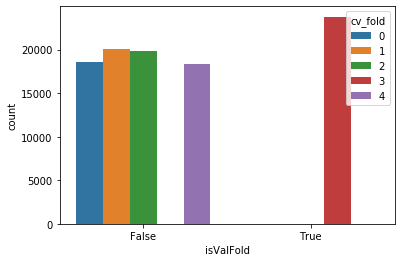

In [3]:
sns.countplot(x='isValFold',hue='cv_fold',data=df)

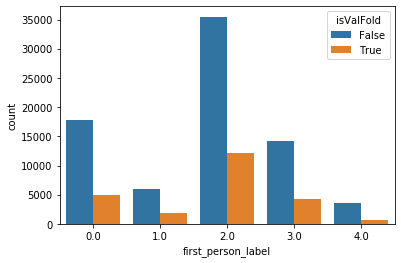

In [4]:
sns.countplot(x='first_person_label',hue='isValFold',data=df)

Get sampled real-fake face pairs.

In [7]:
from util.ImageSampling import getBalancedImageDataFrame

sampled_df = getBalancedImageDataFrame(IMAGE_DIR,df, n_frames_start=7)

In [8]:
# in case we have to restart this notebook

sampled_df.to_csv('../tmp/sampled_df.csv',index=False)
#sampled_df = pd.read_csv('../tmp/sampled_df.csv')

In [9]:
sampled_df.tail()

,path,label,isValFold
254675,/home/joni_juvonen_gmail_com/large_faces_2/mbz...,3,True
254676,/home/joni_juvonen_gmail_com/large_faces_2/vvk...,0,False
254677,/home/joni_juvonen_gmail_com/large_faces_2/wgd...,2,False
254678,/home/joni_juvonen_gmail_com/large_faces_2/fzz...,0,True
254679,/home/joni_juvonen_gmail_com/large_faces_2/lhn...,3,True


In [10]:
# remove directory path from path
sampled_df['path'] = [pth.replace(IMAGE_DIR + '/','') for pth in sampled_df['path'].values]
sampled_df.head()

,path,label,isValFold
0,eyiahkxsvc_0_7.png,0,False
1,jlpdigyqvw_0_7.png,2,False
2,lnipywskyn_0_15.png,0,False
3,zxwkqpqwrh_0_15.png,4,False
4,lqxpsrkxzr_0_9.png,0,False


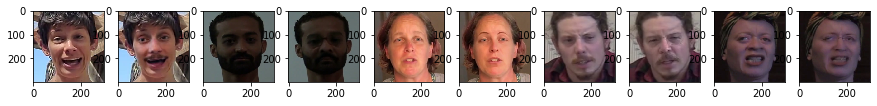

In [11]:
# test that the samples are paired and in order
offset=1048
n_samples = 10

f,ax=plt.subplots(1,n_samples,figsize=(15,15*n_samples))
for i in range(n_samples):
    img_path = os.path.join(IMAGE_DIR,sampled_df.iloc[i+offset]['path'])
    ax[i].imshow(cv2.cvtColor(cv2.imread(str(img_path)),cv2.COLOR_BGR2RGB))

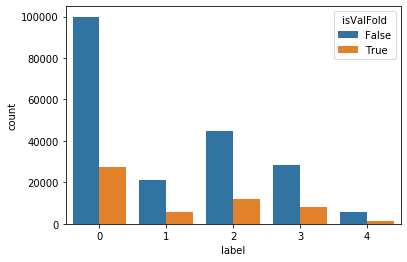

In [12]:
sns.countplot(x='label',hue='isValFold',data=sampled_df)

Change multiclass label back to real/fake binary classes.

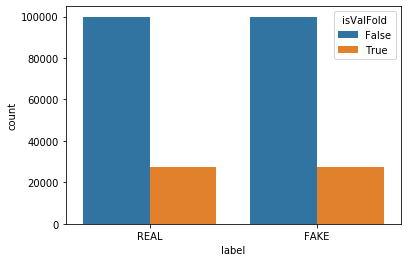

In [13]:
sampled_df['label'] = np.where(sampled_df['label'] > 0, 'FAKE', 'REAL')
sns.countplot(x='label',hue='isValFold',data=sampled_df)

# Train

In [12]:
#%load_ext autoreload
#%autoreload 2

In [14]:
from util.fastaiAugmentations import JPEGAugment, HueSaturationValueAugment

In [15]:
tfms = get_transforms(max_zoom=1.4,#1.0, 
                      max_rotate=10,#0, 
                      max_warp=0.0,#0,
                      max_lighting=0.5,
                      xtra_tfms=[JPEGAugment(p=0.7),
                                 HueSaturationValueAugment(p=0.2),
                                 cutout(n_holes=(1,2), length=(10, 160), p=.5)]) # no zoom, rotate or warp because of the reflect padding
data = (ImageDataBunch.from_df(path=IMAGE_DIR, df=sampled_df)
        .split_from_df('isValFold')
       .label_from_df('label')
       .transform(tfms)
       .databunch(bs=8)
       .normalize(stats=imagenet_stats))

# don't shuffle to keep the ordered real-fake pairs in the same batches
data.train_dl = data.train_dl.new(shuffle=False)

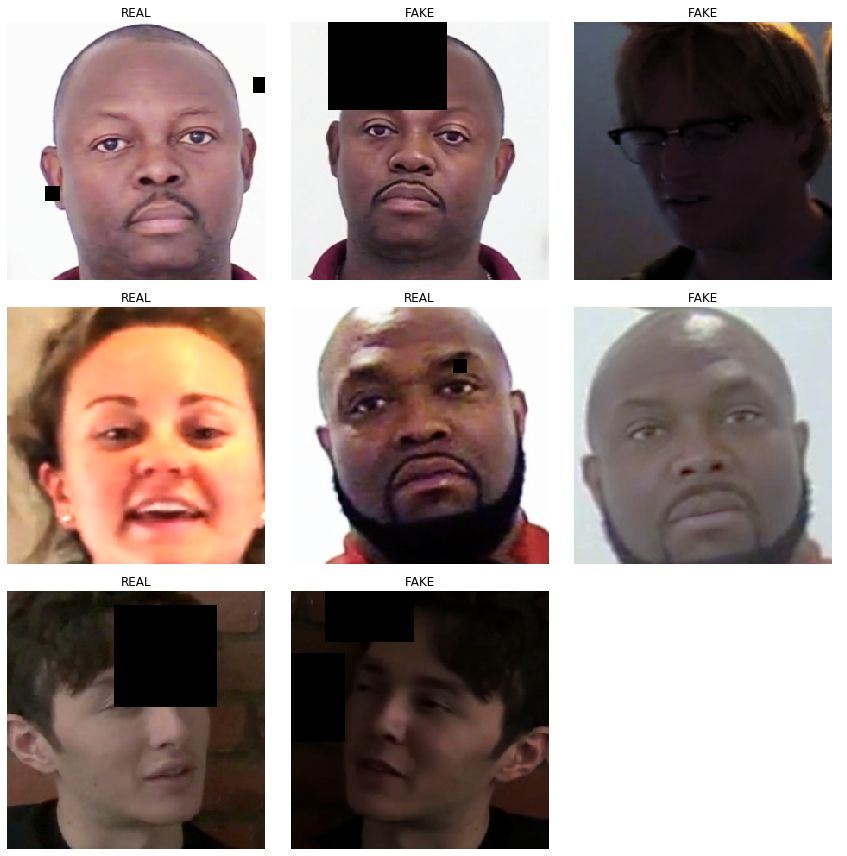

In [16]:
data.show_batch(5)

In [17]:
#from util.PretrainedModels import effnetb6

In [18]:
cbs = [ShowGraph]

learn =  cnn_learner(data,
                     fastai.vision.models.densenet201,#effnetb6,
                     pretrained=True,
                     metrics=[accuracy, error_rate], 
                     ps=0.4,
                     callback_fns=cbs)#.mixup()

In [19]:
learn.freeze() # this leaves only the head for training
len(learn.layer_groups)

3

In [20]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


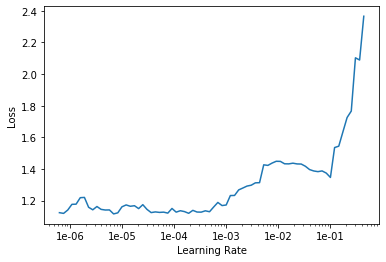

In [21]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.255138,0.340942,0.859924,0.140076,2:32:02
1,0.142162,0.319816,0.880852,0.119148,2:24:55
2,0.078828,0.337128,0.884005,0.115995,2:22:30
3,0.048817,0.433305,0.878339,0.121661,2:20:24


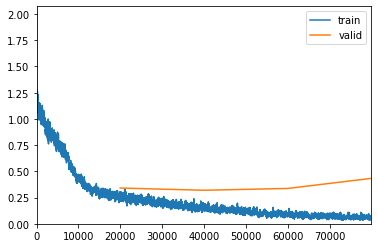

Better model found at epoch 0 with accuracy value: 0.8599236607551575.
Better model found at epoch 1 with accuracy value: 0.8808517456054688.
Better model found at epoch 2 with accuracy value: 0.8840046525001526.


In [22]:
n_epochs = 4
lrs = [1e-5,5e-5,5e-4] # use different lr for different layer groups

save_cb = SaveModelCallback(learn,
                            every='improvement', 
                            monitor='accuracy', 
                            name='best')

learn.fit_one_cycle(n_epochs, lrs, callbacks=[save_cb])

# Export the model

In [24]:
# load best
_=learn.load('best')

In [25]:
if not os.path.exists('../models/large_face_classifier'):
    os.mkdir('../models/large_face_classifier')
os.mkdir('../models/large_face_classifier/2020_03_18-f3')

In [27]:
learn.export(file="/home/joni_juvonen_gmail_com/deepfake-video-detection/models/large_face_classifier/2020_03_18-f3/export.pkl")

# Error analysis

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

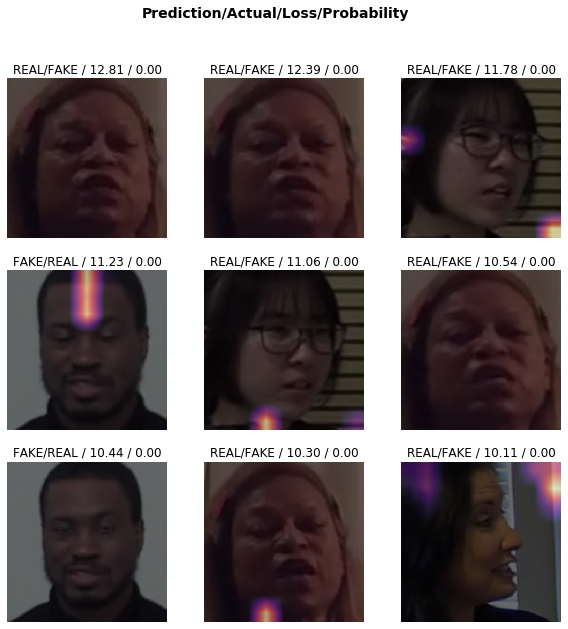

In [29]:
interp.plot_top_losses(9, figsize=(10,10), heatmap=True)

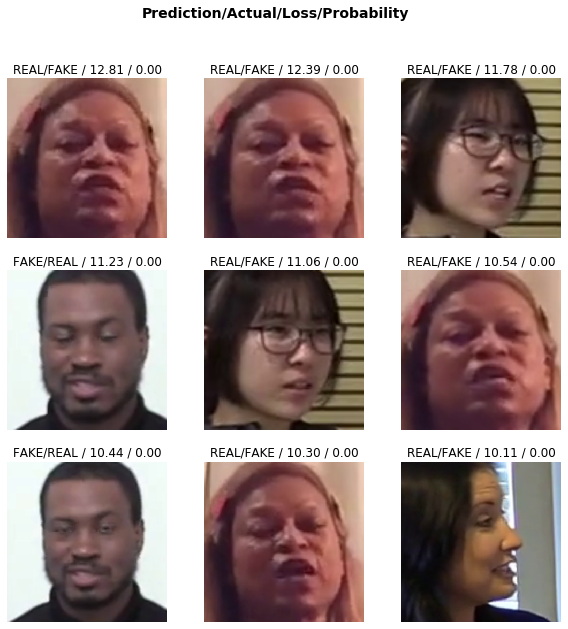

In [30]:
interp.plot_top_losses(9, figsize=(10,10), heatmap=False)

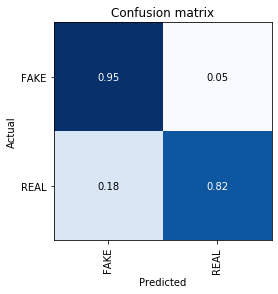

In [31]:
interp.plot_confusion_matrix(normalize=True)

## Plot some random samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


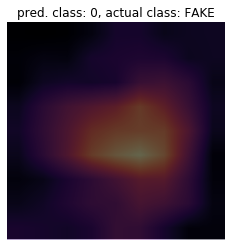

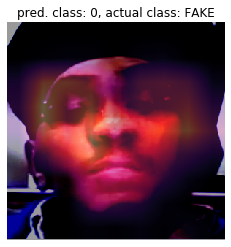

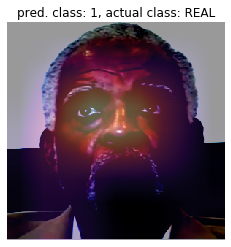

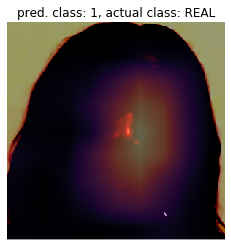

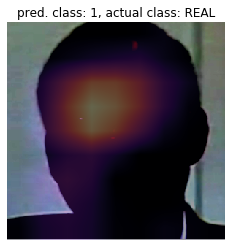

In [32]:
import random
for i in range(5):
    interp.GradCAM(random.randint(0,1000))

In [33]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
from fastai.vision import *

def getFrameLabel(df, df_index, frame_index, person_index=0):
        # get array of frame labels from the dataframe
        frame_lbl_col = 'first_person_frame_labels' if person_index==0 else 'second_person_frame_labels'
        frame_labels = df.loc[df_index,frame_lbl_col]
        
        # check for nan
        if frame_labels == np.nan:
            return np.nan
        
        lbls_int = [int(lbl) for lbl in str(frame_labels).replace('[','').replace(']','').replace(' ','').split(',')]
        return lbls_int[frame_index]
    
def extractIdFromPath(pth):
    parts = pth.split('/')[-1].split('_')
    return parts[0] + '.mp4', int(parts[2].replace('.png',''))
    
def getGtsNPreds(interp):
    ys = []
    preds = []
    for (pth, pred_tensor) in tqdm(zip(list(interp.data.valid_ds.items),list(interp.preds)),total=len(interp.data.valid_ds.items)):
        pred = pred_tensor[1].numpy() > 0.5
        img_id, frame_index = extractIdFromPath(pth)
        df_index = df[df['index']==img_id].index.values[0]
        frame_lbl = getFrameLabel(df, df_index, frame_index)
        ys.append(frame_lbl)
        preds.append(frame_lbl if (pred==(frame_lbl==0)) else int(not pred))
    return ys, preds

In [34]:
ys, preds = getGtsNPreds(interp)

In [35]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(ys,preds)

In [36]:
confusion_mat

array([[17809,  4040,     0,     0,     0],
       [  512,  4205,     0,     0,     0],
       [  386,     0,  9242,     0,     0],
       [  134,     0,     0,  6542,     0],
       [    5,     0,     0,     0,   894]])

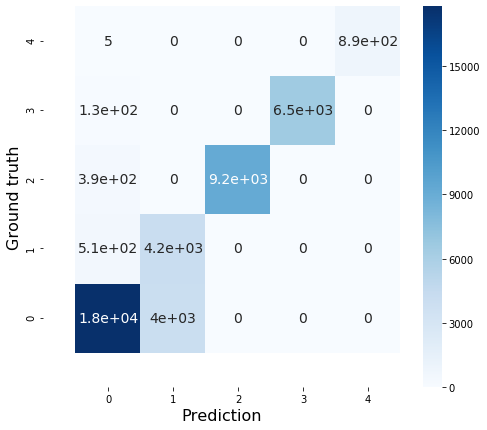

Real type 0 REAL/FAKE binary classification accuracy 81.5 %
Fake type category 1 REAL/FAKE binary classification accuracy 89.1 %
Fake type category 2 REAL/FAKE binary classification accuracy 96.0 %
Fake type category 3 REAL/FAKE binary classification accuracy 98.0 %
Fake type category 4 REAL/FAKE binary classification accuracy 99.4 %


In [37]:
df_cm = pd.DataFrame(confusion_mat, index = list(range(5)),
                  columns = list(range(5)))
plt.figure(figsize = (8,7))
sns.heatmap(df_cm, annot=True, cmap='Blues',annot_kws={"size": 14})
plt.xlim(-0.5,5)
plt.ylim(-0.5,5)
plt.ylabel('Ground truth',fontsize=16)
plt.xlabel('Prediction',fontsize=16)
plt.show()

for lbl_ind in range(5):
    right = confusion_mat[lbl_ind][lbl_ind]
    wrong = confusion_mat[lbl_ind][0 if lbl_ind > 0 else 1]
    print('{2} {0} REAL/FAKE binary classification accuracy {1:.1f} %'.format(lbl_ind,
                                                                              100*right/(right+wrong),
                                                                              'Fake type category' if lbl_ind > 0 else 'Real type'))